# Libs

In [1]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)     # Display all rows

# Load Data (Sumarized Dataframe)

In [ ]:
def df_save(dataframe,file_name,index=False,path_destination=os.path.join(os.getcwd(),r"experiments_data\05_analyses\02_chart")):
	dataframe.to_csv(os.path.join(os.getcwd(),path_destination,file_name), sep=";",index=index,quotechar='"',doublequote=True,encoding="utf-8")

In [ ]:
def load_data(summarized=True):
	path_data_folder = os.path.join(os.getcwd(),r"experiments_data\05_analyses\00_results")
	ls_file_name = sorted(os.listdir(path_data_folder))
	header = pd.read_csv(os.path.join(path_data_folder,ls_file_name[0]), delimiter=';',index_col=None).columns.to_list()
	#header.insert(0, "index")
	header.insert(1, "experiment")
	result_set = pd.DataFrame(columns=header)

	for csv_file in sorted(os.listdir(path_data_folder)):
		df = pd.read_csv(os.path.join(path_data_folder,csv_file), delimiter=';')
		df["experiment"] = int(csv_file[:2])
		result_set = pd.concat([result_set, df], ignore_index=True)
	
	result_set.rename(columns={result_set.columns[0]: "index"}, inplace=True)

	return(result_set)

### Create premisses do monitoring overfitting behaviour

#### Create Premisses columns

In [4]:
df = load_data()

df["train_acc_ten_above"] = (df["accuracy_train"] >= df["accuracy_test"] * 1.10 ).astype(int)
df["train_test_hundred"] = ((df["accuracy_train"] == 100) & (df["accuracy_test"] == 100)).astype(int)
df["f1_hundred"] =  (df["f1_score"] == 100).astype(int)
df["invalid_window"] = ((df["train_acc_ten_above"] == 1) | (df["train_test_hundred"] == 1) | (df["f1_hundred"] == 1)).astype(int)
df.sort_values(by=["experiment", "window","model"], ascending=[True, True, True], inplace=True)

df_save(df,file_name="1.0_all_experiment.csv")

C:\Users\MRX\AppData\Local\Temp\ipykernel_28536\328698733.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_set = pd.concat([result_set, df], ignore_index=True)


#### Summarized premisses by model

In [ ]:
path_data_folder = os.path.join(os.getcwd(),r"experiments_data\05_analyses\02_chart")

agg_dict = {
	"accuracy_train": "mean"
	,"accuracy_test": "mean"
	,"presicion": "mean"
	,"recall": "mean"
	,"f1_score": "mean"
	,"train_acc_ten_above": "sum"
	,"train_test_hundred": "sum"
	,"f1_hundred": "sum"
	,"invalid_window": "sum"
}

try: df = pd.read_csv(os.path.join(path_data_folder,"1.0_all_experiment.csv"),sep=";")
except: df = df.copy()

group = df.columns.to_list()[1:5]

df = df.groupby(group,as_index=False).agg(agg_dict)
df.sort_values(by=["experiment", "window","model"], ascending=[True, True, True], inplace=True)

df_save(df,file_name="2.0_model_summarization.csv")

#### Summarized premisses by window

In [ ]:
path_data_folder = os.path.join(os.getcwd(),r"experiments_data\05_analyses\02_chart")
df = pd.read_csv(os.path.join(path_data_folder,"2.0_model_summarization.csv"),sep=";")
df = df.query("model != 'DUM'").copy()

df.drop(columns=df.columns.tolist()[df.columns.get_loc("accuracy_train"):df.columns.get_loc("train_acc_ten_above")], inplace=True)
df.drop(columns=["model"], inplace=True)
df = df.groupby(df.columns.to_list()[:3],as_index=False).sum()

for col in (df.columns.to_list())[-4:]:
	df[col] = df[col].apply(lambda x: 1 if x != 0 else x)

df.insert(
	loc=6,
	column="valid_window",
	value=df["invalid_window"].apply(lambda x: 1 if x == 0 else 0)
)

#df = df.groupby("experiment","window", "samples_summarized",as_index=False).sum()
		
df_save(df,file_name="2.1_window_summarization.csv")

#### Experiment's behaviour

In [ ]:
path_data_folder = os.path.join(os.getcwd(),r"experiments_data\05_analyses\02_chart")
df = pd.read_csv(os.path.join(path_data_folder,"2.0_model_summarization.csv"),sep=";")
df = df.query("model != 'DUM'").copy()

df.drop(columns=df.columns.tolist()[df.columns.get_loc("accuracy_train"):df.columns.get_loc("train_acc_ten_above")], inplace=True)
df.drop(columns=["model"], inplace=True)
df = df.groupby(df.columns.to_list()[:3],as_index=False).sum()

for col in (df.columns.to_list())[-4:]:
	df[col] = df[col].apply(lambda x: 1 if x != 0 else x)

df.insert(
	loc=6,
	column="valid_window",
	value=df["invalid_window"].apply(lambda x: 1 if x == 0 else 0)
)

df["total"] = 1
df = df.groupby("experiment",as_index=False).sum()
df.drop(columns=["window", "samples_summarized"], inplace=True)
		
df_save(df,file_name="2.2_experiments_behaviour.csv")

#### Melted data to chart

In [ ]:
path_data_folder = os.path.join(os.getcwd(),r"experiments_data\05_analyses\02_chart")
df = pd.read_csv(os.path.join(path_data_folder,"2.2_experiments_behaviour.csv"),sep=";")

df = df.melt(id_vars=["experiment"], var_name='premisses', value_name='quantity')

category_to_order = {
	"train_acc_ten_above": 1
	,"train_test_hundred": 2
	,"f1_hundred": 3
	,"valid_window": 4 
	,"invalid_window": 5 
	,"total": 6
}
df["order"] = df["premisses"].map(category_to_order)


df.rename(columns={"level_1": "premisses", 0: "quantity"},inplace=True)
df.sort_values(["experiment", "order"], inplace=True)
df_save(df,file_name="3.0_melt.csv")

#### Chart window's behaviour

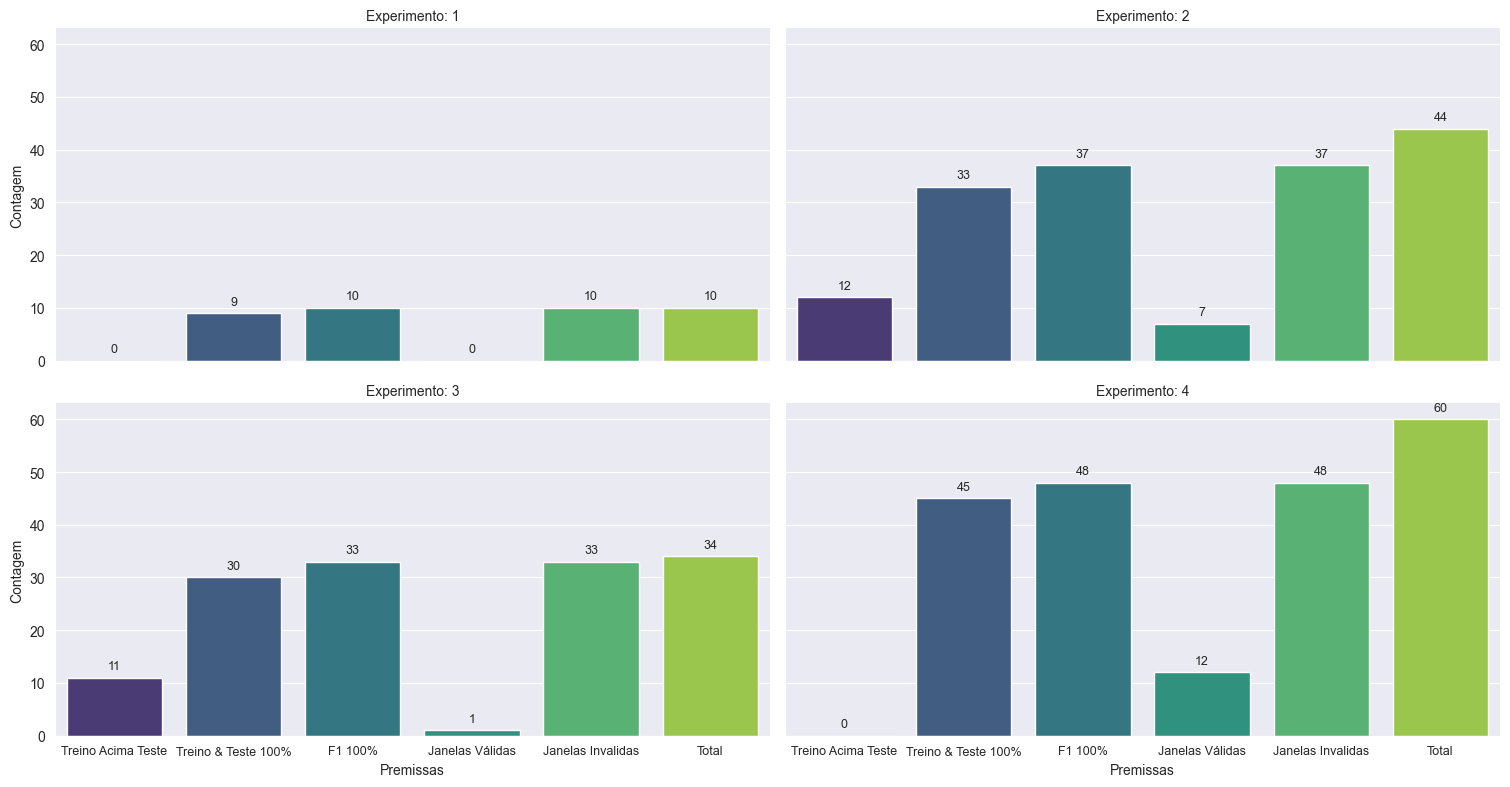

In [ ]:
translate = {
	"train_acc_ten_above": "Treino Acima Teste"
	,"train_test_hundred": "Treino & Teste 100%"
	,"f1_hundred": "F1 100%" 
	,"valid_window": "Janelas Válidas"
	,"invalid_window": "Janelas Invalidas" 
	,"total": "Total"
}

df = pd.read_csv(os.path.join(path_data_folder,"3.0_melt.csv"),sep=";")
df["premisses"] = df['premisses'].map(translate)
abs_path_img = os.path.join(os.getcwd(),r"experiments_data\05_analyses\02_chart\window.svg")
sns.set_style("darkgrid")

g = sns.catplot(
	data=df,
	x='premisses', y='quantity',
	hue='premisses',
	col='experiment',
	kind='bar',
	col_wrap=2,
	height=4,
	aspect=1.9,
	palette="viridis",
	#sharey=False

)
g.set_titles("Experimento: {col_name}")
g.set_axis_labels("Premissas", "Contagem")
plt.tight_layout()

for ax in g.axes.flatten():
	for container in ax.containers:
		ax.bar_label(container, fmt='%.0f', label_type='edge', padding=4,fontsize=9)
		ax.tick_params(axis='x', labelsize=9)

#plt.show()
plt.savefig(abs_path_img,dpi='figure')

# Best Window

## Dataframe

In [12]:
path_data_folder = os.path.join(os.getcwd(),r"experiments_data\05_analyses\02_chart")
#valid window
df_vw = pd.read_csv(os.path.join(path_data_folder,"2.1_window_summarization.csv"),sep=";")
df_vw.query(f"invalid_window == 0", inplace=True)
print(df_vw.info())


<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 47 to 147
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   experiment           20 non-null     int64
 1   window               20 non-null     int64
 2   samples_summarized   20 non-null     int64
 3   train_acc_ten_above  20 non-null     int64
 4   train_test_hundred   20 non-null     int64
 5   f1_hundred           20 non-null     int64
 6   valid_window         20 non-null     int64
 7   invalid_window       20 non-null     int64
dtypes: int64(8)
memory usage: 1.4 KB
None


In [ ]:
agg_dict = {
	"accuracy_train": "mean"
	,"accuracy_test": "mean"
	,"presicion": "mean"
	,"recall": "mean"
	,"f1_score": "mean"
	,"train_acc_ten_above": "sum"
	,"train_test_hundred": "sum"
	,"f1_hundred": "sum"
	,"invalid_window": "sum"
}

path_data_folder = os.path.join(os.getcwd(),r"experiments_data\05_analyses\02_chart")
df = pd.read_csv(os.path.join(path_data_folder,"2.0_model_summarization.csv"),sep=";")
check_cols = ["experiment","window","samples_summarized"]

df.query("model != 'DUM' and invalid_window == 0",inplace=True)
df_merged = df.merge(df_vw[check_cols], on=check_cols, how='inner')
df_merged.drop(columns="model", inplace=True)
group = df_merged.columns.to_list()[0:3]

df_merged = df_merged.groupby(group,as_index=False).agg(agg_dict)
df_merged.sort_values(["experiment","f1_score"], ascending=[True, False], inplace=True)
df_merged["places"] = df_merged.groupby("experiment").cumcount() + 1
df_save(df_merged,file_name="4.0_ranking.csv")

In [15]:
path_data_folder = os.path.join(os.getcwd(),r"experiments_data\05_analyses\02_chart")
df = pd.read_csv(os.path.join(path_data_folder,"4.0_ranking.csv"),sep=";")
#df.drop(columns=df.columns.tolist()[df.columns.get_loc("train_acc_ten_above"):df.columns.get_loc("invalid_window")], inplace=True)
df = df[["experiment", "window", "samples_summarized", "f1_score", "places"]]
df_window = df.pop("window").astype(str) + "x" + df.pop("samples_summarized").astype(str)
df.insert(1, "window", df_window)

df_save(df,"5.0_melt_ranking.csv")

## Chart

#### Single Chart

In [2]:
def chart(experiment,dataframe,path_destination,alpha=0.7):
	if not os.path.exists(path_destination): os.makedirs(path_destination)

	for exp in experiment:
		df_chart = dataframe.query("experiment == @exp")
		path_absolute = os.path.join(path_destination,rf"0{exp}_experiment.svg")

		sns.set_style("darkgrid")
		fig, ax = plt.subplots(figsize=(8, 4.2))  # Adjust size as needed
		# Plot
		sns.barplot(
			data=df_chart,
			x="experiment",
			y="quantity",
			hue="premisses",
			ax=ax,
			palette="viridis",
			alpha=alpha
		)

		# Customize bars
		for bar in ax.patches:
			bar.set_width(bar.get_width() * 0.85)

		# Add labels
		for container in ax.containers:
			ax.bar_label(container, fmt="%.0f", label_type="edge", padding=4, fontsize=9)

		# Customize axes
		ax.set_title("")
		ax.set_ylabel("Quantidade")
		ax.set_ylim(0, 100)
		ax.set_xticklabels([])
		ax.tick_params(axis="x", labelsize=9)
		plt.xlabel("Prêmissas de Sobre Ajuste")

		# Remove default legend
		ax.legend_.remove()

		# Create custom legend
		unique_labels = df["premisses"].unique()
		palette = sns.color_palette("viridis", n_colors=len(unique_labels))

		legend_handles = [
			Patch(facecolor=palette[i], edgecolor='black', label=str(label), alpha=alpha - 0.15)
			for i, label in enumerate(unique_labels)
		]

		legend = fig.legend(
			handles=legend_handles,
			title="Premissas",
			loc="center right",
			bbox_to_anchor=(1.13, 0.5),
			frameon=True,
			fontsize=9,
			title_fontsize=12
		)

		# Style the legend
		plt.draw()
		frame = legend.get_frame()
		frame.set_facecolor("#EAEAF2")
		frame.set_edgecolor("#DBDBE9")
		frame.set_linewidth(1.5)

		plt.savefig(path_absolute,dpi='figure', bbox_inches='tight', pad_inches=0.17)
		plt.close()

In [3]:
path_data_folder = os.path.join(os.getcwd(),r"experiments_data\05_analyses\02_chart")
translate = {
	"train_acc_ten_above": "Treino Acima Teste"
	,"train_test_hundred": "Treino & Teste 100%"
	,"f1_hundred": "F1 100%" 
	,"valid_window": "Janelas Válidas"
	,"invalid_window": "Janelas Invalidas" 
	,"total": "Total"
}
df = pd.read_csv(os.path.join(path_data_folder,"3.0_melt.csv"),sep=";")
df["premisses"] = df['premisses'].map(translate)

chart(experiment=df["experiment"].unique().tolist(),dataframe=df,path_destination=os.path.join(os.getcwd(),"z_img"))

#### Multi Structure to Chart

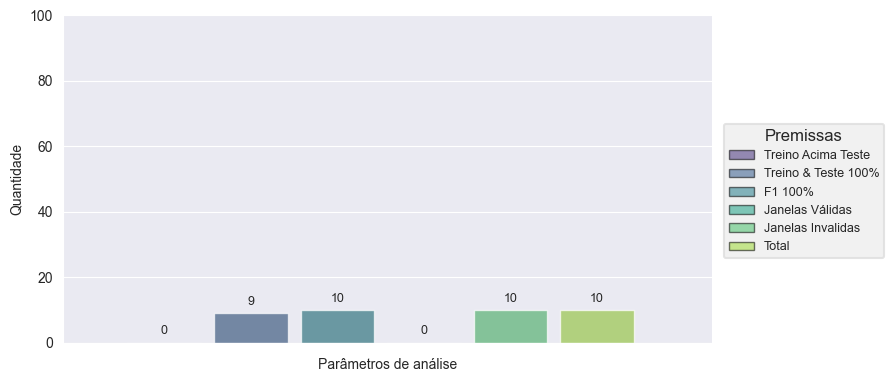

In [3]:
sns.set_style("darkgrid")
alpha = 0.7
# Build plot
g = sns.catplot(
    data=df,
    kind="bar",
    col="experiment",
    col_wrap=2,
    x="experiment",
    y="quantity",
    sharex=False,
    hue="premisses",
    height=4.2,
    aspect=0.9,
    palette="viridis",
    alpha=alpha
)

# Customize each subplot
for ax in g.axes.flat:
    for bar in ax.patches:
        bar.set_width(bar.get_width() * 0.85)
    ax.set_title("")
    ax.set_ylabel("Quantidade")
    ax.set_ylim(0, 100)

    for container in ax.containers:
        ax.bar_label(container, fmt="%.0f", label_type="edge", padding=4, fontsize=9)

    ax.tick_params(axis="x", labelsize=9)

g.set(xticklabels=[])
plt.xlabel("Parâmetros de análise")
g.fig.subplots_adjust(right=1.5)

# Remove Seaborn’s default legend (doesn't handle styling well)
g._legend.remove()

# Create a new legend manually
unique_labels = df["premisses"].unique()
palette = sns.color_palette("viridis", n_colors=len(unique_labels))

legend_handles = [
    Patch(facecolor=palette[i], edgecolor='black', label=str(label), alpha=alpha-0.15)
    for i, label in enumerate(unique_labels)
]

# Add custom legend
#bbox_to_anchor=(0.62, 0.5)
# 	0.965 shifts the box further right beyond the normal bounds (1.0 is fully right-aligned)
#	0.5 centers it vertically
legend = g.fig.legend(
    handles=legend_handles,
    title="Premissas",
    loc="center right",
    bbox_to_anchor=(0.965, 0.5), #shifts the box further right beyond the normal bounds (1.0 is fully right-aligned)
    frameon=True,
    fontsize=9,
    title_fontsize=12,
)

# Style it properly
plt.draw()
frame = legend.get_frame()
frame.set_facecolor("#eee")
frame.set_edgecolor("#ddd")
frame.set_linewidth(1.5)


plt.show()

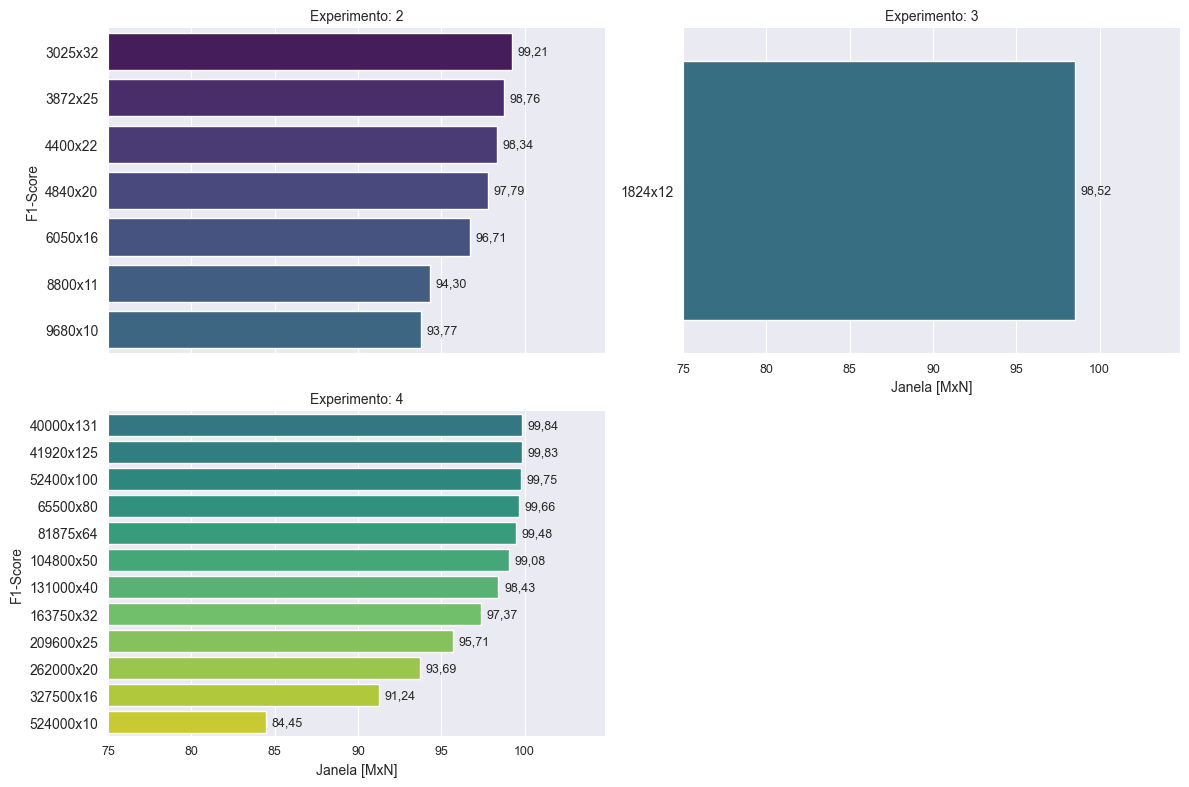

In [ ]:
df = pd.read_csv(os.path.join(path_data_folder,"5.0_melt_ranking.csv"),sep=";")
abs_path_img = os.path.join(os.getcwd(),r"experiments_data\05_analyses\02_chart\5.1_best_window.svg")
sns.set_style("darkgrid")

g = sns.catplot(
	data=df,
	x='f1_score', y='window',
	hue='window',
	col='experiment',
	kind='bar',
	col_wrap=2,
	height=4,
	aspect=1.5,
	palette="viridis",
	sharey=False
	#sharex=False

)
g.set_titles("Experimento: {col_name}")
g.set_axis_labels("Janela [MxN]", "F1-Score")
plt.tight_layout()

for ax in g.axes.flatten():
	for container in ax.containers:
		# Custom formatting function
		def custom_formatter(x):
			return f'{x:.2f}'.replace('.', ',')

		ax.bar_label(container, labels=[custom_formatter(bar.get_width()) for bar in container],
					 label_type='edge', padding=4, fontsize=9)

	ax.tick_params(axis='x', labelsize=9)
	ax.set_xlim(left=75)


#plt.show()
plt.savefig(abs_path_img,dpi='figure')